<a href="https://colab.research.google.com/github/Lexiusleeah/Capstone-Lynch/blob/main/scanCapLynch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Scanpy tutorial by Lexius Lynch

In [47]:
!pip install leidenalg #would not run clustering code, needed to upload this package

In [53]:
import leidenalg


In [7]:
!pip install scanpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.1/122.1 kB 13.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 9.0 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=ffb92df579c4aeb889f3148eb91f62b1616e2c4c7c7fe833ef4ce0374b9583b8
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8027 sha256=d7133e54e2e2612d419d2105902af0df3ba2724290a78c4dd4b49c3e5d359b36
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd

In [9]:
import scanpy as sc

In [15]:
!mkdir data
!wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
!cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
!mkdir write

--2024-03-12 15:57:13--  http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.0.173, 104.18.1.173, 2606:4700::6812:ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz [following]
--2024-03-12 15:57:13--  https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7621991 (7.3M) [application/x-tar]
Saving to: ‘data/pbmc3k_filtered_gene_bc_matrices.tar.gz’

data/pbmc3k_filtere 100%[===================>]   7.27M  --.-KB/s    in 0.1s    

2024-03-12 15:57:13 (56.2 MB/s) - ‘data/pbmc3k_filtered_gene_bc_matric

In [11]:
results_file = "write/pbmc3k.h5ad"  # the file that will store the analysis results


In [16]:
adata = sc.read_10x_mtx(
    "data/filtered_gene_bc_matrices/hg19/",  # the directory with the `.mtx` file
    var_names="gene_symbols",  # use gene symbols for the variable names (variables-axis index)
    cache=True,  # write a cache file for faster subsequent reading
)

In [17]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

 **Preprocessing**


 Show those genes that yield the highest fraction of counts in each single cell, across all cells.



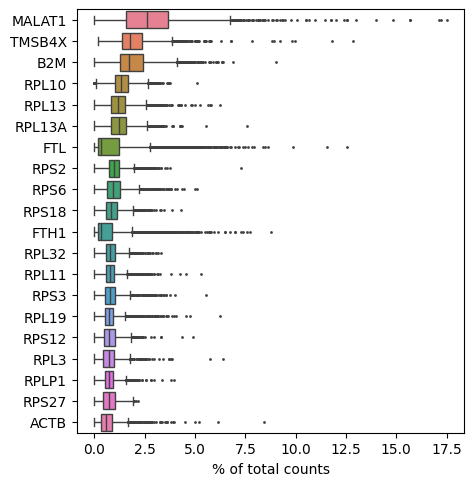

In [18]:
sc.pl.highest_expr_genes(adata, n_top=20)



Basic filtering

In [19]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [20]:
# annotate the group of mitochondrial genes as "mt"
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

A violin plot of some of the computed quality measures:

the number of genes expressed in the count matrix
the total counts per cell
the percentage of counts in mitochondrial genes

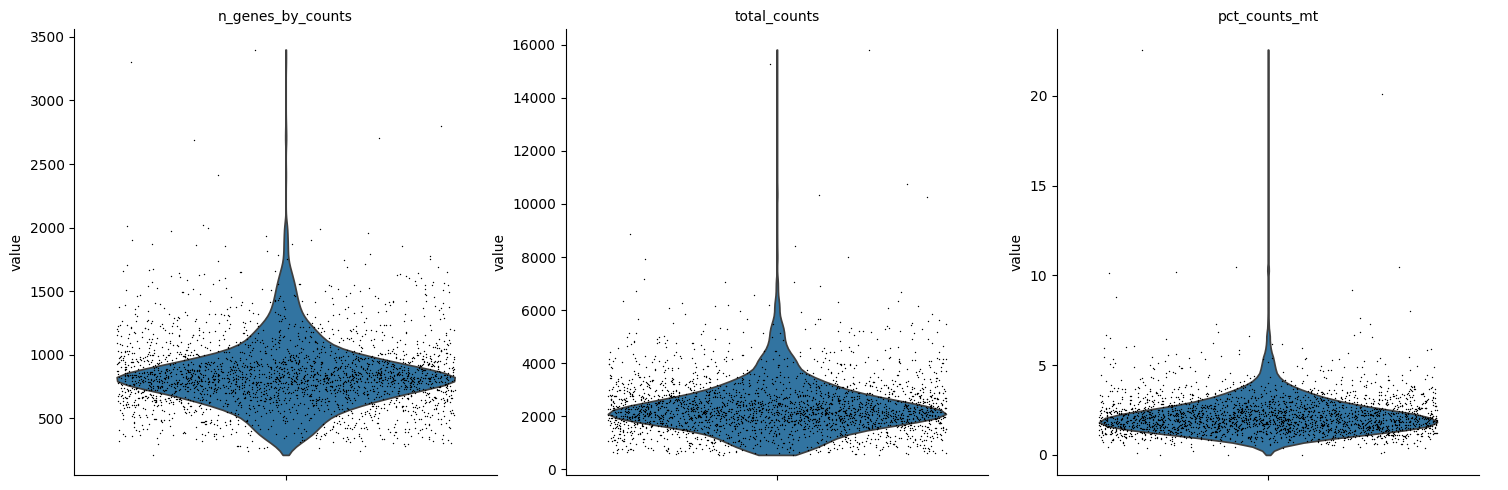

In [21]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

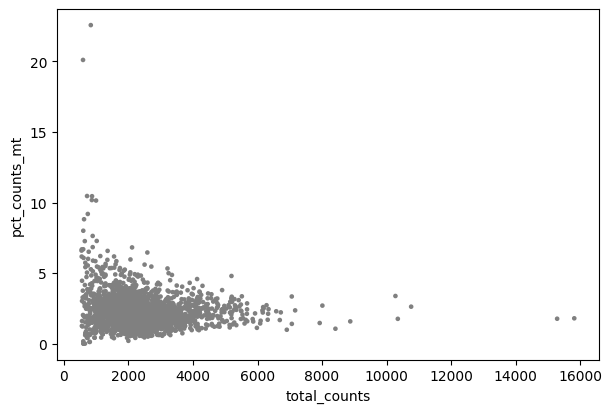

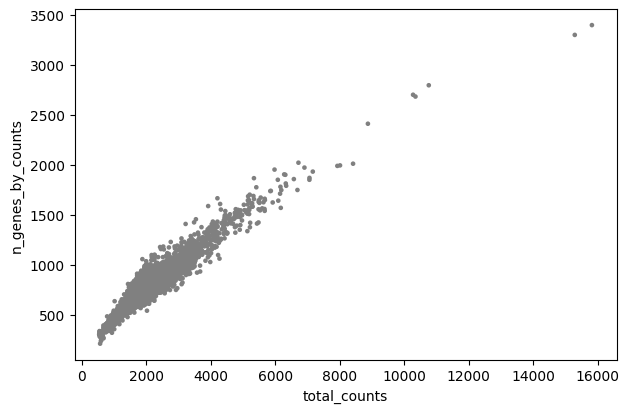

In [22]:
# Remove cells that have too many mitochondrial genes expressed or too many total counts:

sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

In [23]:
#slice the anndata
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :].copy()
# Total-count normalize (library-size correct) the data matrix to 10,000 reads per cell, so that counts become comparable among cells
sc.pp.normalize_total(adata, target_sum=1e4)


In [24]:
# Logarithmize the data:
sc.pp.log1p(adata)



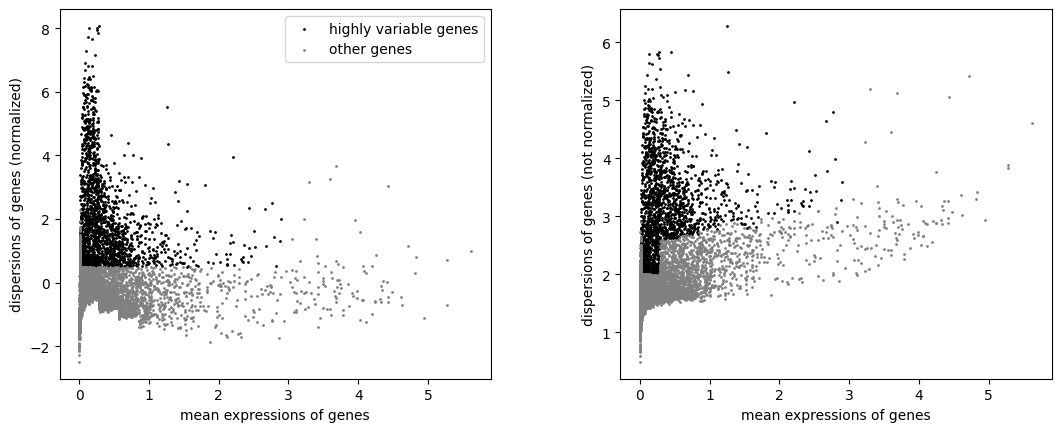

In [26]:
# Identify highly-variable genes.
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

sc.pl.highly_variable_genes(adata)


Set the .raw attribute of the AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object.

You can get back an AnnData of the object in .raw by calling .raw.to_adata().

In [27]:
adata.raw = adata


In [28]:
# filteirng
adata = adata[:, adata.var.highly_variable]


In [29]:
# Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])


In [30]:
# Scale each gene to unit variance. Clip values exceeding standard deviation 10.

sc.pp.scale(adata, max_value=10)



**Principal component analysis**

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [32]:
sc.tl.pca(adata, svd_solver="arpack")


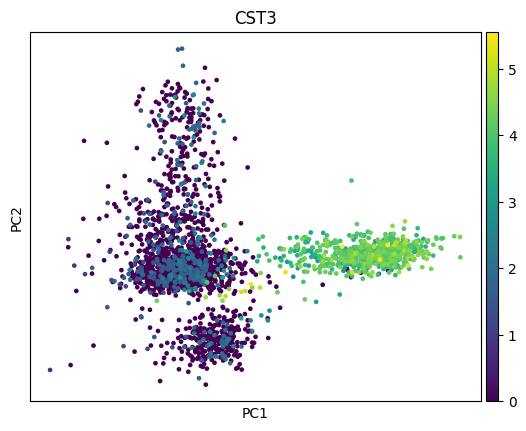

In [33]:
sc.pl.pca(adata, color="CST3")


This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells

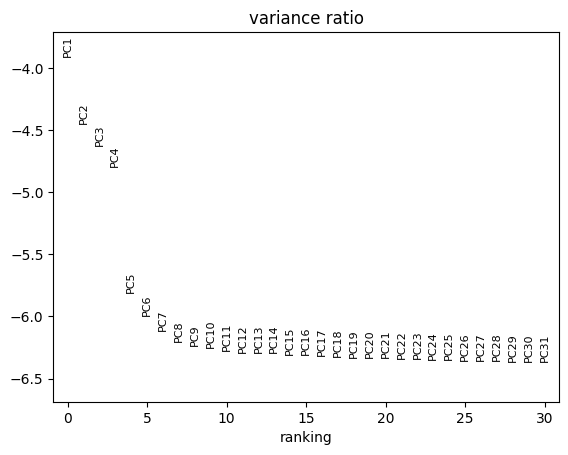

In [35]:
sc.pl.pca_variance_ratio(adata, log=True)
#save the result
adata.write(results_file)
adata.write(results_file)


**Embedding the neighborhood graph**

In [38]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)


In [39]:
# Embedding the graph in two dimensions using UMAP, better preserves trajectories.
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')


ValueError: You need to run `tl.leiden` or `tl.louvain` to compute community labels, or specify `groups='an_existing_key'`

In [40]:
sc.tl.umap(adata)


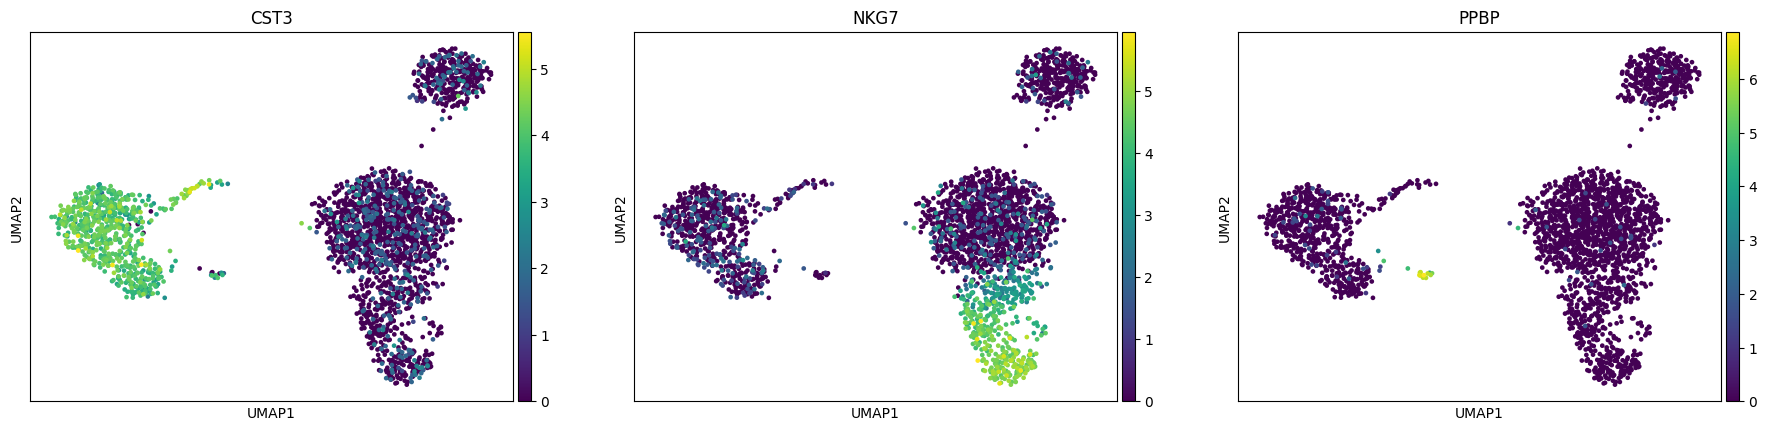

In [41]:
sc.pl.umap(adata, color=["CST3", "NKG7", "PPBP"])


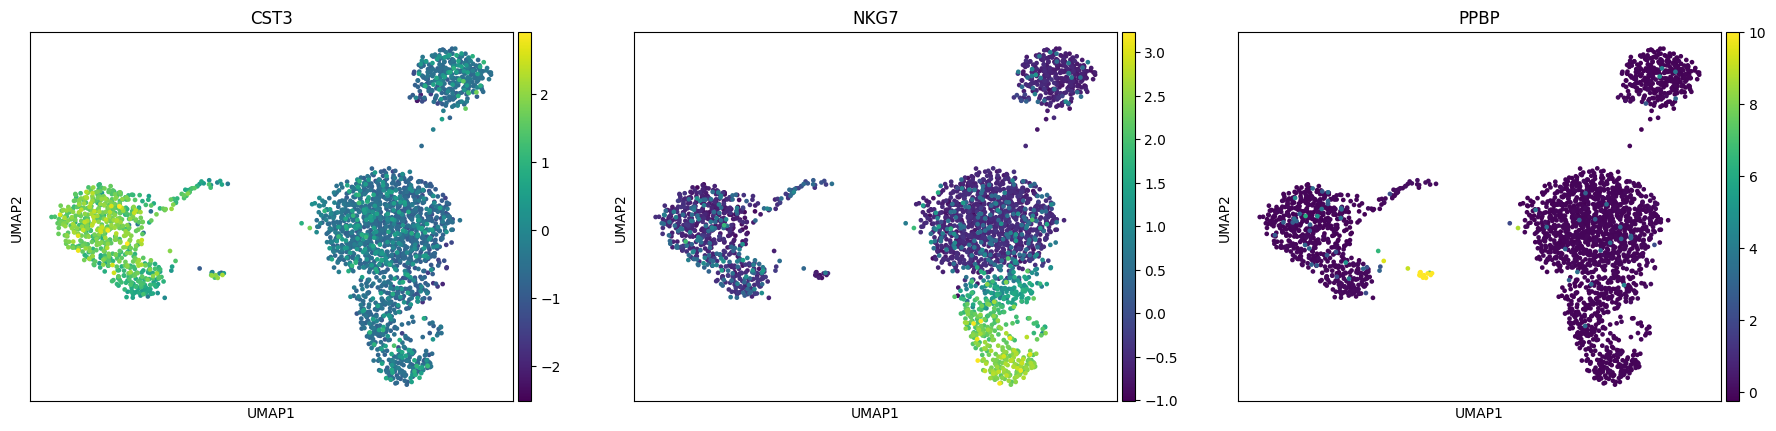

In [42]:
# You can also plot the scaled and corrected gene expression by explicitly stating that you don’t want to use .raw.
sc.pl.umap(adata, color=["CST3", "NKG7", "PPBP"], use_raw=False)


**Clustering the neighborhood graph**

Leiden clustering directly clusters the neighborhood graph of cells

In [54]:
sc.tl.leiden(
    adata,
    resolution=0.9,
    random_state=0,
     #removing flavor argument
    n_iterations=2,
    directed=False,
)

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


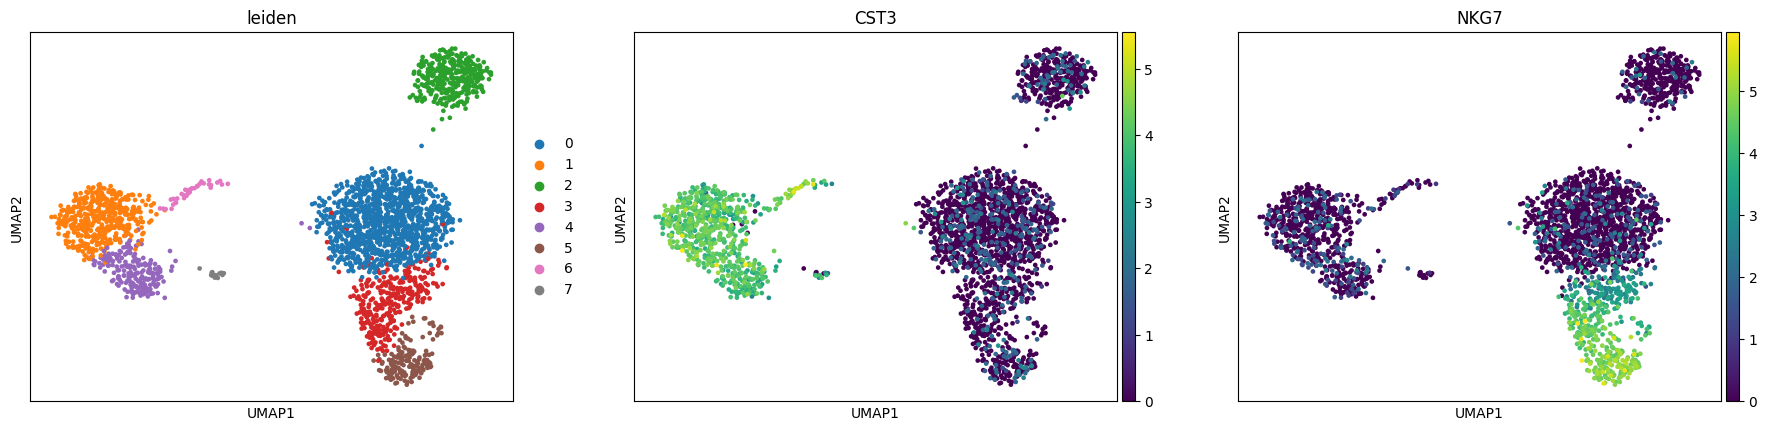

In [57]:
sc.pl.umap(adata, color=["leiden", "CST3", "NKG7"])
adata.write(results_file) #save the result


**Finding marker genes**

Let us compute a ranking for the highly differential genes in each cluster. For this, by default, the .raw attribute of AnnData is used in case it has been initialized before. The simplest and fastest method to do so is the t-test.

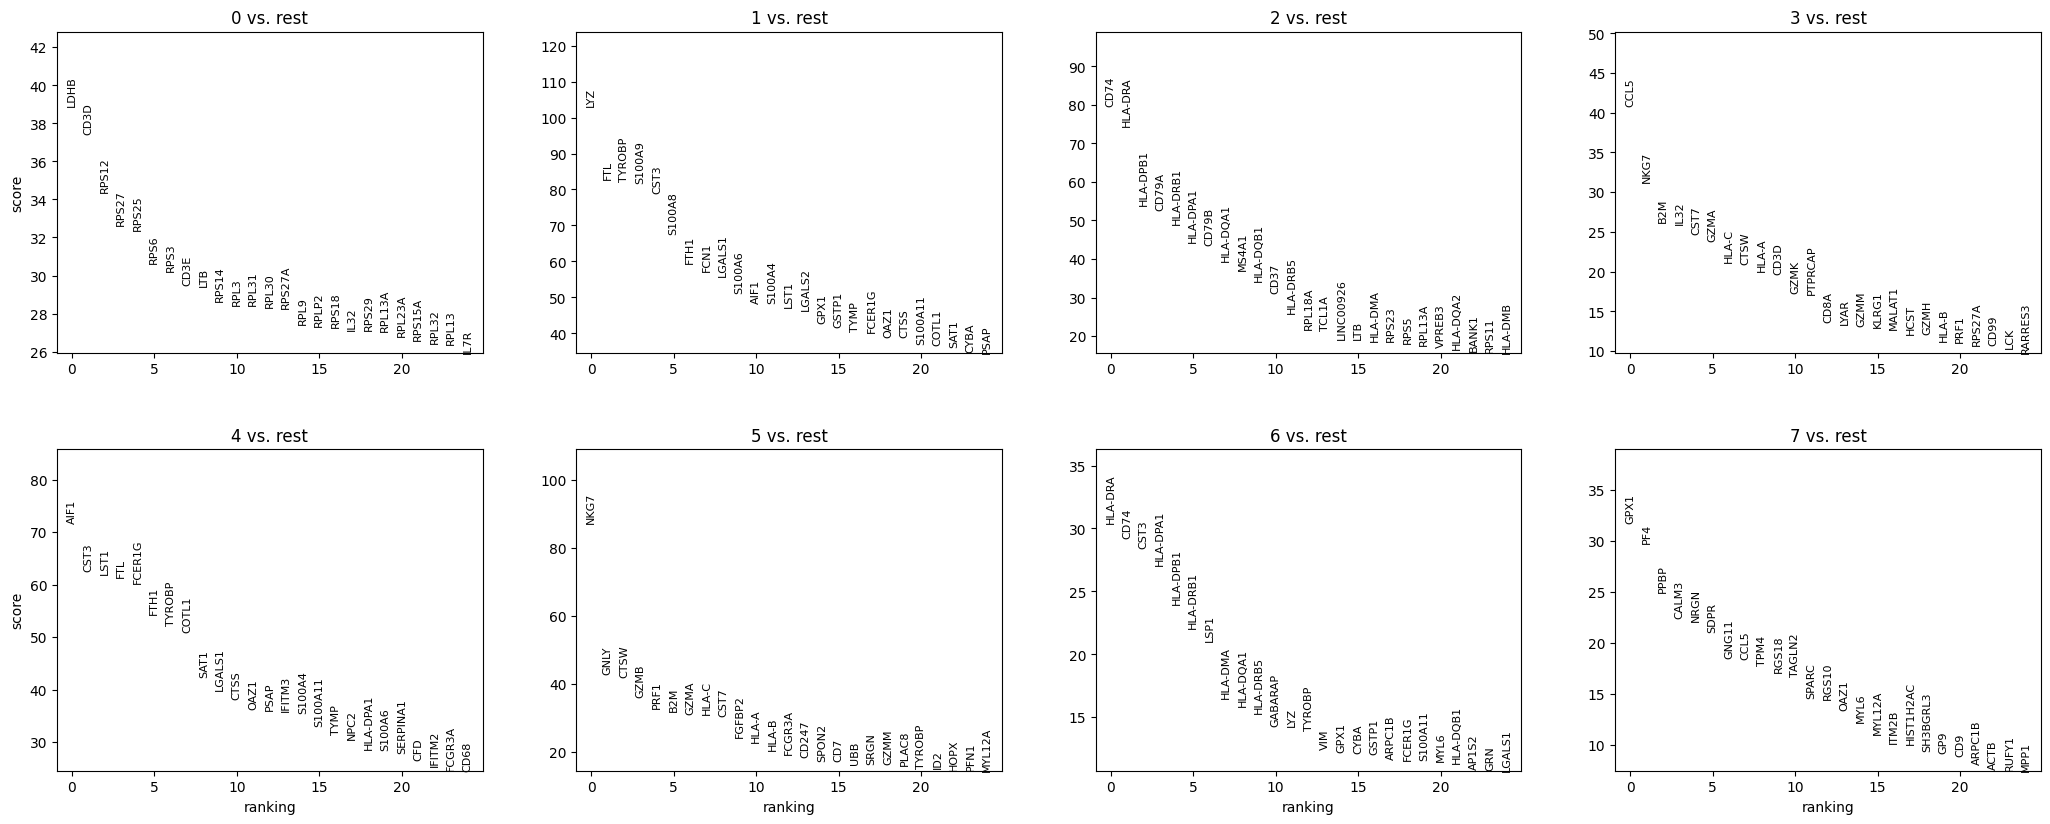

In [58]:
sc.tl.rank_genes_groups(adata, "leiden", method="t-test")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [59]:
sc.settings.verbosity = 2  # reduce the verbosity


ranking genes
    finished (0:00:09)


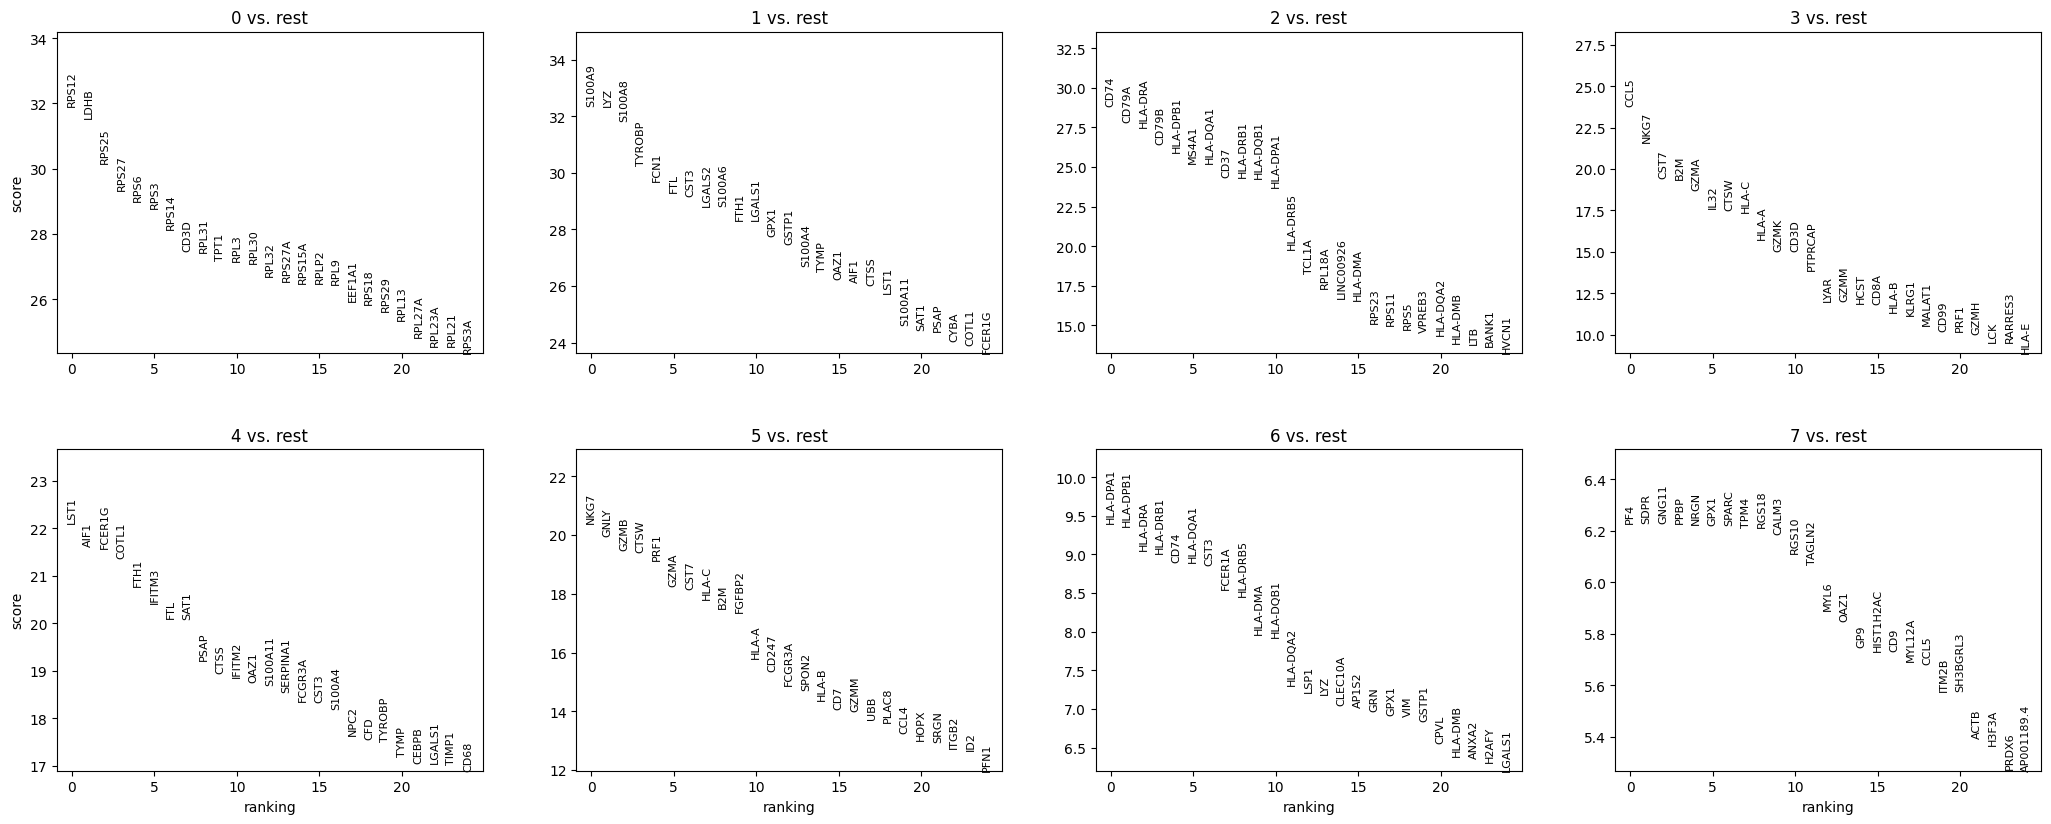

In [61]:
# The result of a Wilcoxon rank-sum (Mann-Whitney-U) test is very similar.
sc.tl.rank_genes_groups(adata, "leiden", method="wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
adata.write(results_file) #save result

ranking genes
    finished (0:02:06)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


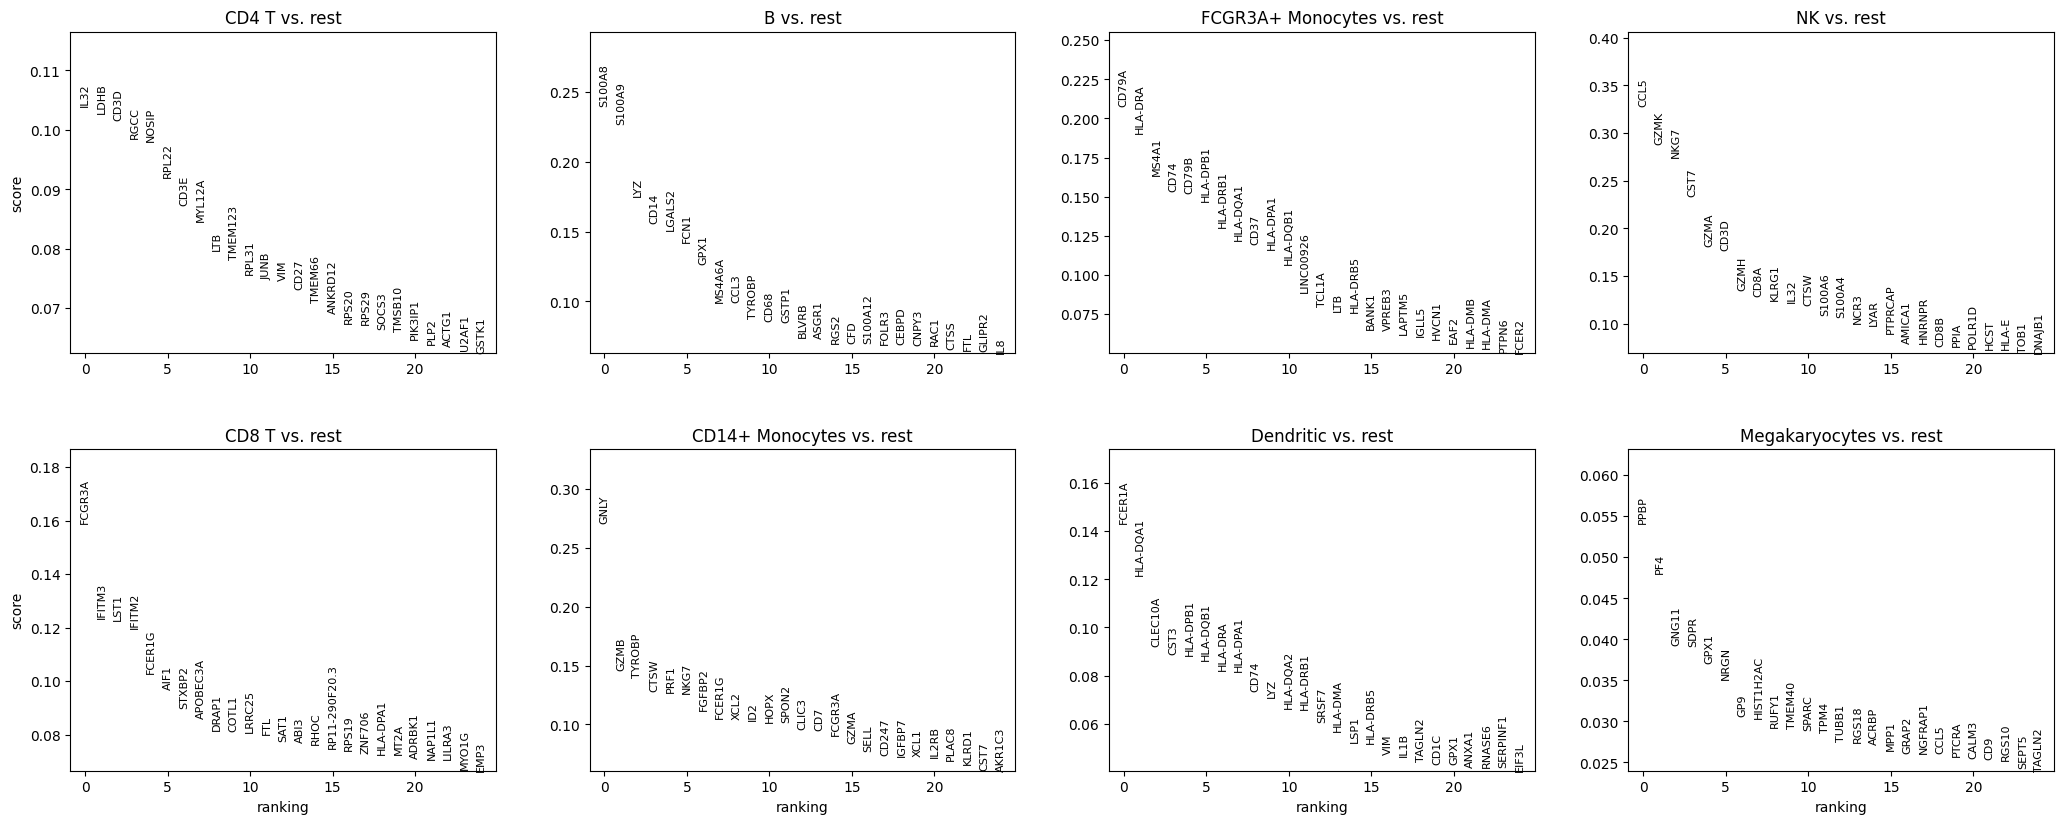

In [74]:
# rank genes using logistic regression.
# The essential difference is that here, we use a multi-variate appraoch whereas conventional differential tests are uni-variate
sc.tl.rank_genes_groups(adata, "leiden", method="logreg", max_iter=1000)
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [64]:
# Let us also define a list of marker genes for later reference.

marker_genes = [
    *["IL7R", "CD79A", "MS4A1", "CD8A", "CD8B", "LYZ", "CD14"],
    *["LGALS3", "S100A8", "GNLY", "NKG7", "KLRB1"],
    *["FCGR3A", "MS4A7", "FCER1A", "CST3", "PPBP"],
]


In [65]:
# reload the save result of the Wilcoxon Rank-Sum test
adata = sc.read(results_file)

/usr/local/lib/python3.10/dist-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [66]:
# Show the 10 top ranked genes per cluster 0, 1, …, 7 in a dataframe.
pd.DataFrame(adata.uns["rank_genes_groups"]["names"]).head(5)


,0,1,2,3,4,5,6,7
0,RPS12,S100A9,CD74,CCL5,LST1,NKG7,HLA-DPA1,PF4
1,LDHB,LYZ,CD79A,NKG7,AIF1,GNLY,HLA-DPB1,SDPR
2,RPS25,S100A8,HLA-DRA,CST7,FCER1G,GZMB,HLA-DRA,GNG11
3,RPS27,TYROBP,CD79B,B2M,COTL1,CTSW,HLA-DRB1,PPBP
4,RPS6,FCN1,HLA-DPB1,GZMA,FTH1,PRF1,CD74,NRGN


In [67]:
# Get a table with the scores and groups.

result = adata.uns["rank_genes_groups"]
groups = result["names"].dtype.names
pd.DataFrame(
    {
        group + "_" + key[:1]: result[key][group]
        for group in groups
        for key in ["names", "pvals"]
    }
).head(5)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p,7_n,7_p
0,RPS12,9.638217e-224,S100A9,7.006710e-230,CD74,2.487145e-183,CCL5,1.448089e-125,LST1,2.838395e-108,NKG7,1.923512e-92,HLA-DPA1,5.422417e-21,PF4,4.722886e-10
1,LDHB,1.981459e-218,LYZ,7.591243e-230,CD79A,1.679730e-170,NKG7,5.674145e-104,AIF1,1.246622e-103,GNLY,1.513503e-88,HLA-DPB1,7.591860e-21,SDPR,4.733899e-10
2,RPS25,8.320090e-200,S100A8,4.376632e-222,HLA-DRA,6.942399e-167,CST7,3.097996e-84,FCER1G,2.757131e-103,GZMB,1.405777e-84,HLA-DRA,1.306768e-19,GNG11,4.733899e-10
3,RPS27,2.073537e-189,TYROBP,3.208884e-201,CD79B,2.569135e-154,B2M,1.083019e-83,COTL1,2.607744e-101,CTSW,7.510027e-84,HLA-DRB1,1.865104e-19,PPBP,4.744938e-10
4,RPS6,4.252906e-185,FCN1,1.108884e-193,HLA-DPB1,3.580735e-148,GZMA,2.037873e-78,FTH1,6.692392e-96,PRF1,1.053180e-81,CD74,5.853161e-19,NRGN,4.800511e-10


ranking genes
    finished (0:00:03)


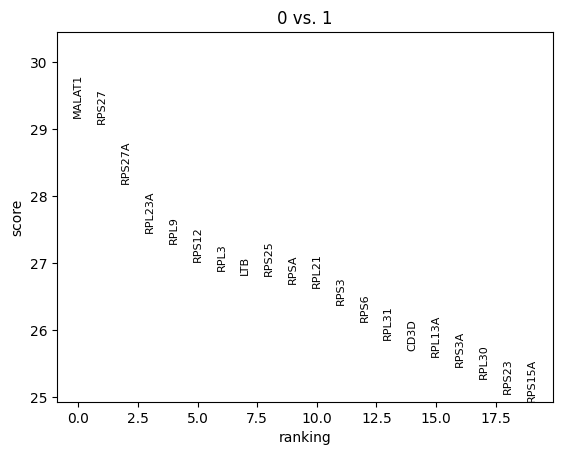

In [68]:
#compare single cluster
sc.tl.rank_genes_groups(adata, "leiden", groups=["0"], reference="1", method="wilcoxon")
sc.pl.rank_genes_groups(adata, groups=["0"], n_genes=20)

Cell annotation

In [69]:
# Actually mark the cell types.
new_cluster_names = [
    "CD4 T",
    "B",
    "FCGR3A+ Monocytes",
    "NK",
    "CD8 T",
    "CD14+ Monocytes",
    "Dendritic",
    "Megakaryocytes",
]
adata.rename_categories("leiden", new_cluster_names)


Omitting rank_genes_groups/names as old categories do not match.
Omitting rank_genes_groups/scores as old categories do not match.
Omitting rank_genes_groups/pvals as old categories do not match.
Omitting rank_genes_groups/pvals_adj as old categories do not match.
Omitting rank_genes_groups/logfoldchanges as old categories do not match.


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


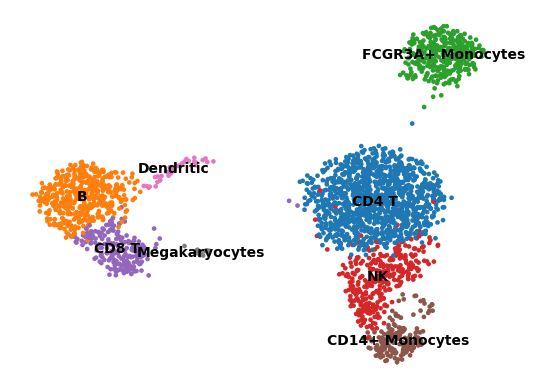

In [70]:
sc.pl.umap(
    adata, color="leiden", legend_loc="on data", title="", frameon=False, save=".pdf"
)

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


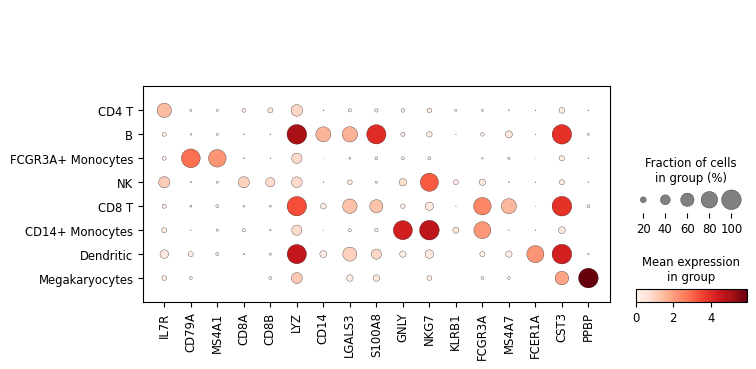

In [71]:
# visualize the marker genes.
sc.pl.dotplot(adata, marker_genes, groupby="leiden");


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_stacked_violin.py:461: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  row_ax = sns.violinplot(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_stacked_violin.py:461: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  row_ax = sns.violinplot(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_stacked_violin.py:461: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  row_ax = sns.violinplot(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_stacked_violin.py:461: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and

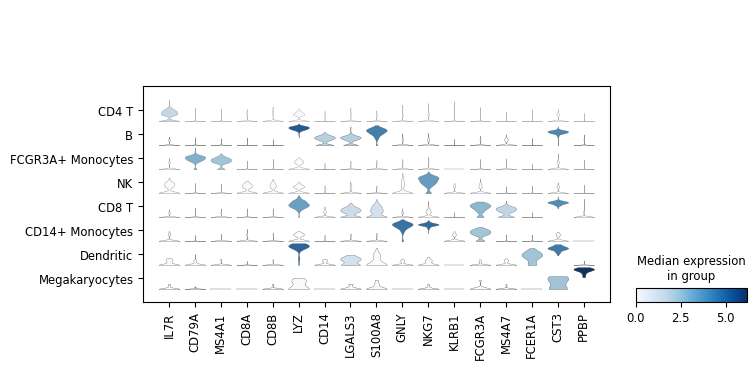

In [72]:
# compact violin graph
sc.pl.stacked_violin(adata, marker_genes, groupby="leiden");


In [73]:
adata # the AnnData accumlated the following annotations


AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [ ]:
# `compression='gzip'` saves disk space, and slightly slows down writing and subsequent reading
adata.write(results_file, compression="gzip")

If you want to share this file with people who merely want to use it for visualization, a simple way to reduce the file size is by removing the dense scaled and corrected data matrix. The file still contains the raw data used in the visualizations in adata.raw.

In [ ]:
adata.raw.to_adata().write("./write/pbmc3k_withoutX.h5ad")